# Plotting of Evaluation Results

*Here, use seaborn, which calculates a bootstrapped 95% CI, which looks nicer and more narrow than 
with matplotlib*

Results aggregated with `aggregator.py 0 49`. Specify which results to aggregate in `settings.py`.
`0 49` means aggregate run 0-49; adjust as needed.

Results are inside `transformed_0-49`. `ci-t-metrics.csv` are the correct results.

Goal: Show that the algorithms achieve good results in terms of successful flows and delay.
Compare the different algorithms. Also differnt capacities. Focus on DFN network (58 nodes) and large GTS CE (149 nodes).

Seems like SPR1 is just worse than SPR2. I might drop it from the paper.

## Definition of plotting functions & settings

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# settings
# result_dir = 'transformed_0-49'
# result_dir_bsp = 'transformed_bsp_150-199'
result_dir = 'transformed_distr_with_load'
result_dir_bsp = 'transformed_bsp_with_load'
configs = ['hc', 'lnc']
network = 'dfn_58.graphml'

labels = ['GCASP', 'SBC', 'BSP', 'BSP+']

sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

In [17]:
def plot_successful(df, labels):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    df_successful = df[df['Metric'] == 'perc_successful_flows']
    print(df_successful['Algorithm'].unique())
    
    # *100 to convert to percent
    sns.lineplot(df_successful['Ingress %']*100, df_successful['Value']*100, hue=df_successful['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_successful['Algorithm'], markers=True, markersize=9, legend=False)
    
    ax.set_xlabel('Amount of Ingress Nodes [%]')
    ax.set_ylabel('Successful Flows [%]')
    ax.set_ylim(62, 101)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)
    
    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/{network_name}_{config}_flows.pdf')

In [18]:
def plot_delay(df, labels):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})
    
    df_delay = df[df['Metric'] == 'avg_end2end_delay_of_processed_flows']
    print(df_delay['Algorithm'].unique())
    
    sns.lineplot(df_delay['Ingress %']*100, df_delay['Value'], hue=df_delay['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_delay['Algorithm'], markers=True, markersize=9, legend=False)
    
    ax.set_xlabel('Amount of Ingress Nodes [%]')
    ax.set_ylabel('Avg. End-to-End Delay [ms]')
    ax.set_ylim(30, 70)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)
    
    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/{network_name}_{config}_delay.pdf')

In [19]:
def plot_load(df, load, labels):
    assert load == 'node' or load == 'link', "Specify whether to plot node or link load"
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

    if load == 'node':
        df_load = df[df['Metric'] == 'avg_node_load']
    else:
        df_load = df[df['Metric'] == 'avg_link_load']
    print(df_load['Algorithm'].unique())

    sns.lineplot(df_load['Ingress %']*100, df_load['Value']*100, hue=df_load['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_load['Algorithm'], markers=True, markersize=9, legend=False)

    ax.set_xlabel('Amount of Ingress Nodes [%]')
    if load == 'node':
        ax.set_ylabel('Avg. Node Utilization [%]')
        ax.set_ylim(0, 61)
    else:
        ax.set_ylabel('Avg. Link Utilization [%]')
        ax.set_ylim(0, 48)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)

    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/{network_name}_{config}_load_{load}.pdf')

## Plot results for all configs

Metric: flow
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Metric: delay
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Metric: load
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']


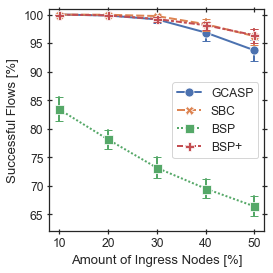

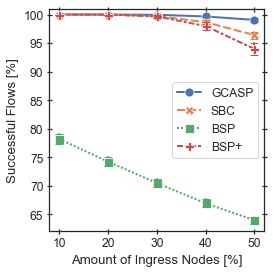

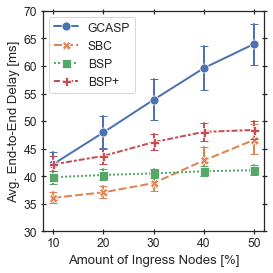

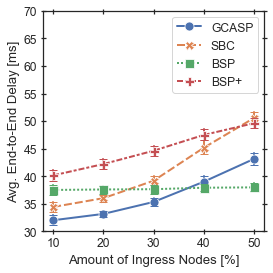

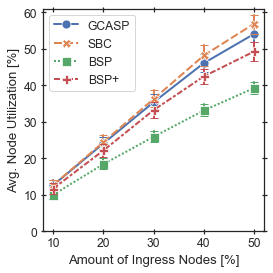

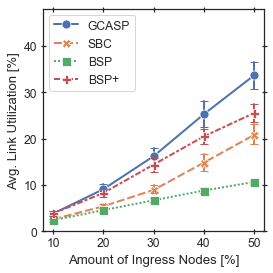

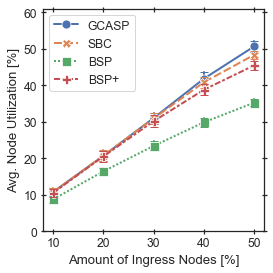

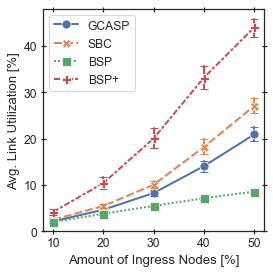

In [20]:
for metric in ['flow', 'delay', 'load']:
    print(f"Metric: {metric}", flush=True)
    for config in configs:
        print(f"Config: {config}", flush=True)
        df = pd.read_csv(f'{result_dir}/{config}/{network}/{metric}/ci-t-metrics.csv',
                         names=['Ingress %', 'Value', 'Metric', 'Algorithm'])
        df = df.append(pd.read_csv(f'{result_dir_bsp}/{config}/{network}/{metric}/ci-t-metrics.csv',
                         names=['Ingress %', 'Value', 'Metric', 'Algorithm']))
        df = df[df['Algorithm'] != 'spr1']

        if metric == 'flow':
            plot_successful(df, labels=labels)
        if metric == 'delay':
            plot_delay(df, labels=labels)
        if metric == 'load':
            plot_load(df, load='node', labels=labels)
            plot_load(df, load='link', labels=labels)